In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import accuracy
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Collaborative filtering based Recommendation system with Matrix factorization

## SVD with surprise library

### Load files

In [2]:
import gzip
import json
import pandas as pd

with gzip.open("Grocery_and_Gourmet_Food_5.json.gz", "rt") as f:
    data = []
    for line in f:
        try:
            obj = json.loads(line)
            data.append(obj)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

In [3]:
reviews = pd.DataFrame(data)
reviews

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5.0,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5.0,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5.0,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1143855,5.0,True,"09 8, 2017",A223YRQH2Z5T1D,B01HJF6FRA,flint5292,"As a new vegan, it is sometimes difficult to r...","As a new vegan, it is sometimes difficult to ...",1504828800,4,NaN,NaN
1143856,5.0,True,"08 4, 2017",A38GDA4TB9EILT,B01HJF6FRA,Moriah Bolyard,The best thing ever is ordering a product you ...,The best thing ever is ordering a product you ...,1501804800,3,NaN,NaN
1143857,5.0,True,"07 4, 2017",A2025PN7HDC5BO,B01HJF6FRA,M.C,I used to love ranch before I became vegan. It...,Just what the vegan ordered!,1499126400,5,NaN,NaN
1143858,5.0,True,"06 7, 2017",A1NY7XWC7EPQOA,B01HJF6FRA,Greensboro,I cannot have dairy nor gluten. This is as cl...,This is as close to Ranch as I will ever be ab...,1496793600,2,NaN,NaN


In [4]:
reviews.rename(columns={'asin': 'productID', 'reviewerID': 'userID', 'overall': 'rating'}, inplace=True)
reviews.drop(columns=['verified','reviewTime','reviewerName','reviewText','summary','vote','unixReviewTime','style','image'], inplace=True)
reviews

,rating,userID,productID
0,5.0,A1QVBUH9E1V6I8,4639725183
1,5.0,A3GEOILWLK86XM,4639725183
2,5.0,A32RD6L701BIGP,4639725183
3,5.0,A2UY1O1FBGKIE6,4639725183
4,5.0,A3QHVBQYDV7Z6U,4639725183
...,...,...,...
1143855,5.0,A223YRQH2Z5T1D,B01HJF6FRA
1143856,5.0,A38GDA4TB9EILT,B01HJF6FRA
1143857,5.0,A2025PN7HDC5BO,B01HJF6FRA
1143858,5.0,A1NY7XWC7EPQOA,B01HJF6FRA


In [5]:
import pandas as pd

file_path = "Grocery_and_Gourmet_Food.csv"

ratings = pd.read_csv(file_path)

In [6]:
ratings.rename(columns={'1888861614': 'productID', 'ALP49FBWT4I7V': 'userID', '5.0': 'rating'}, inplace=True)
ratings.drop(columns=['1370304000'], inplace=True)
ratings

,productID,userID,rating
0,1888861614,A1KPIZOCLB9FZ8,4.0
1,1888861614,A2W0FA06IYAYQE,4.0
2,1888861614,A2PTZTCH2QUYBC,5.0
3,1888861614,A2VNHGJ59N4Z90,4.0
4,1888861614,ATQL0XOLZNHZ4,1.0
...,...,...,...
5074154,B01HJHSVG6,AGOPF2VTEOP57,5.0
5074155,B01HJHSVG6,A5X5TI4JCH9CN,3.0
5074156,B01HJHSVG6,A1WMQQLC3TVAFI,4.0
5074157,B01HJHSVG6,ALVP6JZRTEDY6,5.0


In [7]:
merged_df = pd.merge(reviews, ratings, how='inner')
merged_df

,rating,userID,productID
0,5.0,A1QVBUH9E1V6I8,4639725183
1,5.0,A3GEOILWLK86XM,4639725183
2,5.0,A32RD6L701BIGP,4639725183
3,5.0,A2UY1O1FBGKIE6,4639725183
4,5.0,A3QHVBQYDV7Z6U,4639725183
...,...,...,...
1308351,5.0,A223YRQH2Z5T1D,B01HJF6FRA
1308352,5.0,A38GDA4TB9EILT,B01HJF6FRA
1308353,5.0,A2025PN7HDC5BO,B01HJF6FRA
1308354,5.0,A1NY7XWC7EPQOA,B01HJF6FRA


In [8]:
from surprise import Dataset
from surprise import Reader

In [9]:
reader = Reader(rating_scale=(1, 5))

#### Create a user-item matrix: The dataset needs to be transformed into a user-item matrix, where each row represents a user and each column represents an item.

In [10]:
data = Dataset.load_from_df(merged_df[['userID', 'productID', 'rating']], reader)

#### Splitting data into training and testing

In [11]:
trainset, testset = train_test_split(data, test_size=0.2)

#### Train the model: We can use the Surprise library to train an SVD-based model. This involves setting up a Reader object to specify the rating scale, loading the user-item matrix into a Dataset object, and training the SVD model using the fit() method.

In [12]:
model = SVD(biased='False')

In [13]:
model.fit(trainset)

Generate recommendations: Once the model is trained, we can use it to generate recommendations for a given user. We can do this by using the predict() method to get predicted ratings for all items, sorting them by the predicted rating, and returning the top k items.


In [14]:
predictions = model.test(testset)

In [15]:
type(predictions)

list

In [16]:
predictions[0]

Prediction(uid='A39L1MXQ1E8R2P', iid='B00LYKG5AO', r_ui=5.0, est=4.757539775043325, details={'was_impossible': False})

In [17]:
predictions[0][1]

'B00LYKG5AO'

### Recommendation

In [18]:
def recommend_product():
    import random

    # Select a user (you can replace this with any userID from your dataset)
    userID = 'A397VK3Q5GVWGO'

    # Get all unique product IDs
    product_ids = data.df['productID'].unique()

    random_product_ids = random.sample(list(product_ids), 10)

    # Generate predictions for the selected user
    predictions_new = [(productID, model.predict(userID, productID).est) for productID in random_product_ids]

    # Sort the predictions based on the estimated ratings in descending order
    #predictions.sort(key=lambda x: x[1], reverse=True)

    # Print the predictions
    for productID, rating in predictions_new:
        print(f"Predicted rating for product {productID}: {rating}")

In [19]:
recommend_product()

Predicted rating for product B00I9E7S0Y: 4.178803882388904
Predicted rating for product B005SSM64W: 3.8270882716987678
Predicted rating for product B0084972ZA: 4.394481072376448
Predicted rating for product B00FORQ0JY: 4.513346296649605
Predicted rating for product B005TH72DM: 4.312989068994574
Predicted rating for product B0012BUR8Q: 4.1071358614232665
Predicted rating for product B008IYS1YW: 4.0374275145743095
Predicted rating for product B0068VU48I: 4.4379078819972975
Predicted rating for product B000QFRJSA: 4.40274257072507
Predicted rating for product B005ECOBRM: 4.558919520411944


### Different Performance Measure
#### Evaluate the model: To evaluate the accuracy of the model, we can use various measures such as RMSE, MAE

#### RMSE

In [20]:
rmse = accuracy.rmse(predictions)

RMSE: 0.8754


In [21]:
mae = accuracy.mae(predictions)

MAE:  0.5651


#### Compare RMSE value for different value of K(Recommendation)

In [22]:
# Define the range of number of recommendations to try
n_recommendations = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Compute the accuracy metrics for different number of recommendations
rmse_scores = []
mae_scores = []
for n in n_recommendations:
    # Train the model on the training set
    model.fit(trainset)
    # Make predictions on the test set for n recommendations
    predictions = model.test(testset[:n])
    # Compute and append the RMSE and MAE scores
    rmse_scores.append(accuracy.rmse(predictions, verbose=False))
    mae_scores.append(accuracy.mae(predictions, verbose=False))

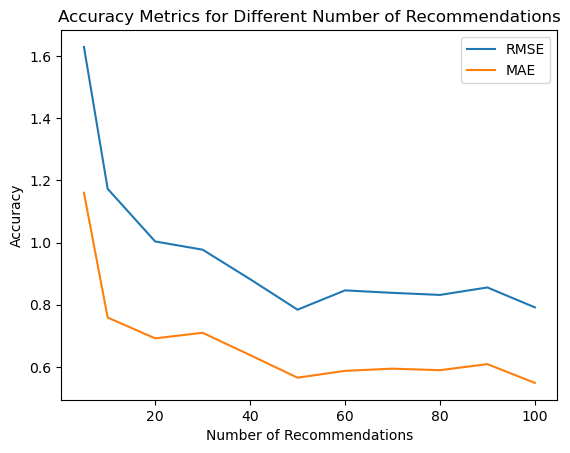

In [23]:
# Plot the RMSE and MAE scores against the number of recommendations
plt.plot(n_recommendations, rmse_scores, label='RMSE')
plt.plot(n_recommendations, mae_scores, label='MAE')
plt.title('Accuracy Metrics for Different Number of Recommendations')
plt.xlabel('Number of Recommendations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

         as number of 'k' recommendation increases Error also increases